PREPROCESSING DATASET

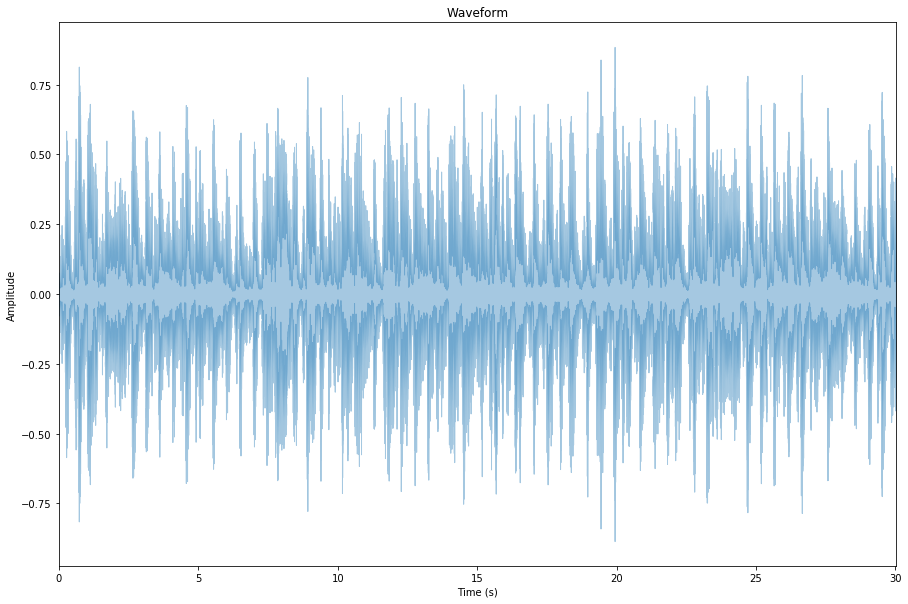

In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

file = "Desktop/genres/blues/blues.00000.wav"

signal, sample_rate = librosa.load(file, sr=22050)

plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

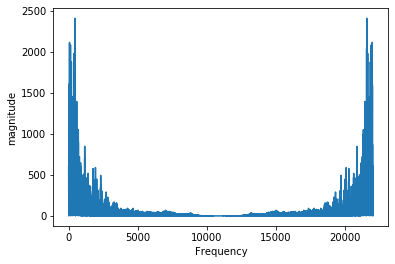

In [3]:
fft = np.fft.fft(signal)
magnitude=np.abs(fft)
frequency=np.linspace(0,sample_rate,len(magnitude))
plt.plot(frequency , magnitude)
plt.xlabel("Frequency")
plt.ylabel("magnitude")
plt.show()

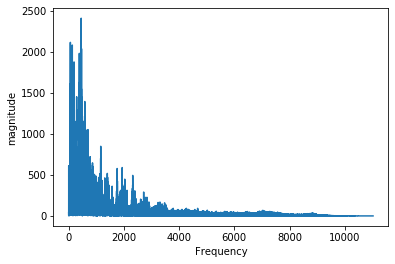

In [4]:
left_frequency=frequency[:int(len(frequency)/2)]
left_magnitude=magnitude[:int(len(frequency)/2)]

plt.plot(left_frequency , left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("magnitude")
plt.show()

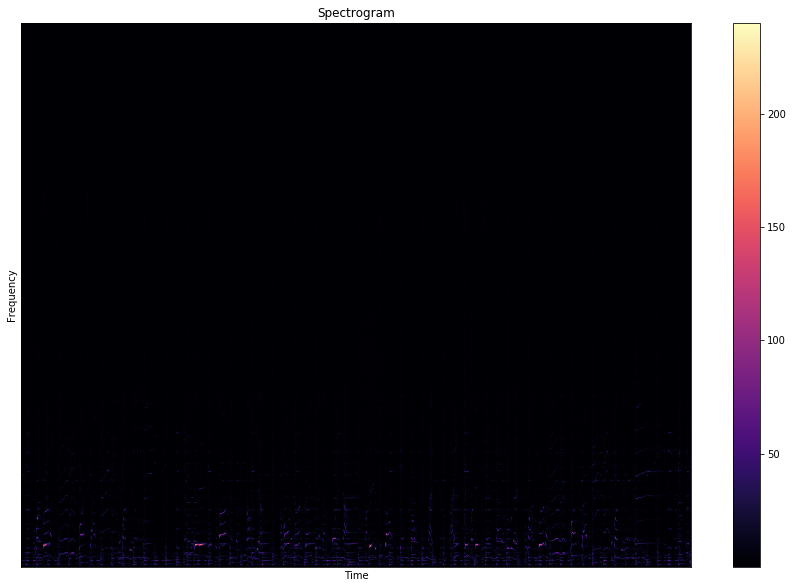

In [5]:
n_fft=2048
hop_length = 512
stft=librosa.core.stft(signal , n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

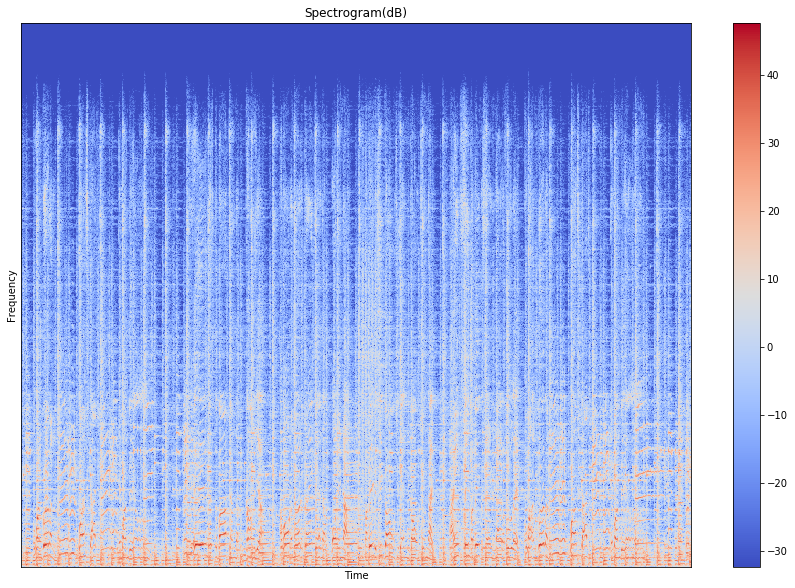

In [6]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram(dB)")
plt.show()

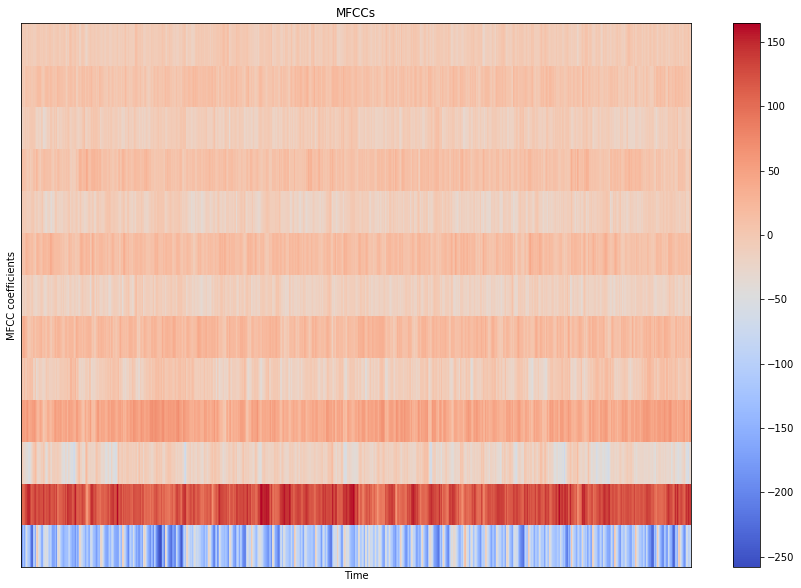

In [7]:
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

plt.show()

CREATING DATASET

In [8]:
import json
import os
import math
import librosa

In [9]:
DATASET_PATH = "Desktop/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    data = {
        "mapping": [],
        "labels": [], 
        "mfcc": [] 
    }
    
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: genres\blues
Desktop/genres\blues\blues.00000.wav, segment:1
Desktop/genres\blues\blues.00000.wav, segment:2
Desktop/genres\blues\blues.00000.wav, segment:3
Desktop/genres\blues\blues.00000.wav, segment:4
Desktop/genres\blues\blues.00000.wav, segment:5
Desktop/genres\blues\blues.00000.wav, segment:6
Desktop/genres\blues\blues.00000.wav, segment:7
Desktop/genres\blues\blues.00000.wav, segment:8
Desktop/genres\blues\blues.00000.wav, segment:9
Desktop/genres\blues\blues.00000.wav, segment:10
Desktop/genres\blues\blues.00001.wav, segment:1
Desktop/genres\blues\blues.00001.wav, segment:2
Desktop/genres\blues\blues.00001.wav, segment:3
Desktop/genres\blues\blues.00001.wav, segment:4
Desktop/genres\blues\blues.00001.wav, segment:5
Desktop/genres\blues\blues.00001.wav, segment:6
Desktop/genres\blues\blues.00001.wav, segment:7
Desktop/genres\blues\blues.00001.wav, segment:8
Desktop/genres\blues\blues.00001.wav, segment:9
Desktop/genres\blues\blues.00001.wav, segment:10
Desktop/genr

Implementing MUSIC GENRE CLASSIFIER USING CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

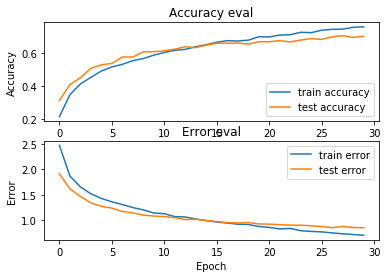

2499/1 - 1s - loss: 1.2033 - accuracy: 0.6775

Test accuracy: 0.677471
Target: 8, Predicted label: [8]


In [10]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data_10.json"


def load_data(data_path):
   

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model


def predict(model, X, y):
    X = X[np.newaxis, ...] 
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
    plot_history(history)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    predict(model, X_to_predict, y_to_predict)